# Energy Use

Analysing household energy use

In [9]:
from datetime import timedelta, datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt# Import a scoring metric to compare methods

## Read Data

In [116]:
raw_data = pd.read_csv(os.path.join("data", "consumption.csv.zip"))
# Drop whitespace
raw_data[' Start'] = raw_data[' Start'].apply(lambda x: x.strip())
raw_data[' End'] = raw_data[' End'].apply(lambda x: x.strip())

raw_data['energy'] = raw_data['Consumption (kWh)'] # Better column label

# Create date objects
raw_data['StartDate'] = pd.to_datetime(raw_data[' Start'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
raw_data['EndDate'] =  pd.to_datetime(raw_data[' End'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)

# Index is the start point for 30 minute interval
#raw_data['Date'] = raw_data['StartDate']
#raw_data = raw_data.set_index('Date')
raw_data.index = pd.DatetimeIndex(raw_data.StartDate)
raw_data.index.name = "Date"

# Now just take the columns that we want
df = raw_data.loc[:,['energy']]

# Make some useful ones
#df['Day'] = df.index.map(lambda x:x.day) # (had to do it this way before I had the DateTimeIndex set up properly)
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
# Hour as a decimal
df['hour'] = df.index.map(lambda x:x.hour) + df.index.map(lambda x:x.minute) / 60
# Season (thanks https://stackoverflow.com/questions/44124436/python-datetime-to-season)
df['season'] = df.index.month%12 // 3 + 1

df

,energy,day,month,year,dayofyear,hour,season
Date,,,,,,,
2022-01-01 00:00:00+00:00,0.198,1,1,2022,1,0.0,1
2022-01-01 00:30:00+00:00,3.519,1,1,2022,1,0.5,1
2022-01-01 01:00:00+00:00,4.198,1,1,2022,1,1.0,1
2022-01-01 01:30:00+00:00,3.736,1,1,2022,1,1.5,1
2022-01-01 02:00:00+00:00,3.695,1,1,2022,1,2.0,1
...,...,...,...,...,...,...,...
2023-01-14 21:30:00+00:00,0.835,14,1,2023,14,21.5,1
2023-01-14 22:00:00+00:00,0.167,14,1,2023,14,22.0,1
2023-01-14 22:30:00+00:00,0.113,14,1,2023,14,22.5,1


## Sanity check plots

Plot to check the data look sensible

<AxesSubplot: title={'center': 'Daily Energy Use'}, xlabel='dayofyear'>

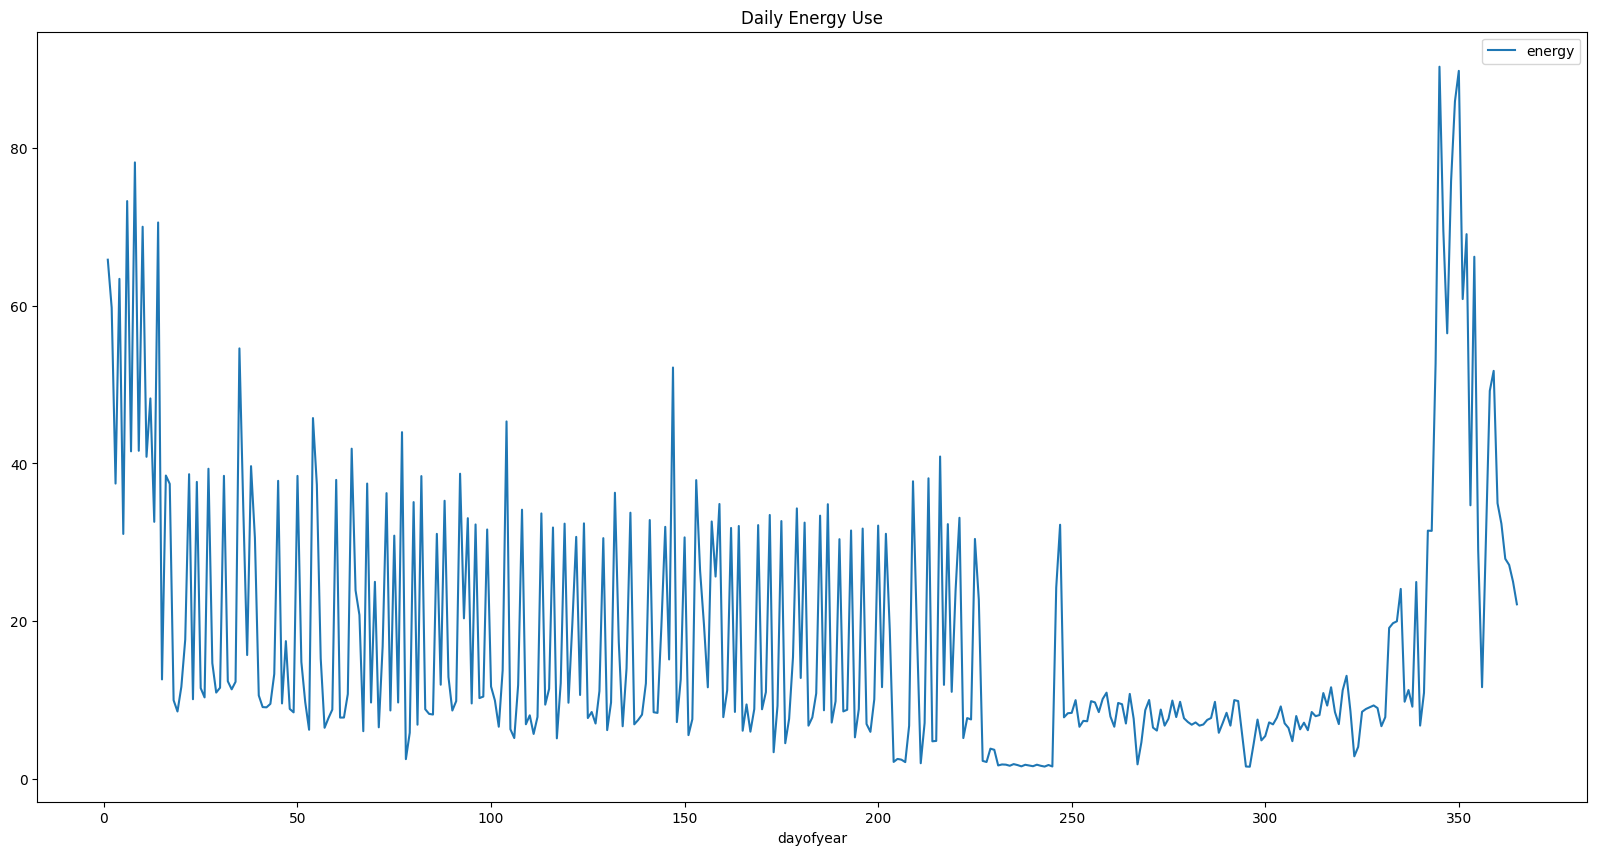

In [117]:
# Daily totals
df.loc[:,['energy', 'dayofyear']].groupby(['dayofyear']).sum().plot(
    figsize=(20, 10), title="Daily Energy Use")

<AxesSubplot: title={'center': 'Seasonal energy use'}, xlabel='season'>

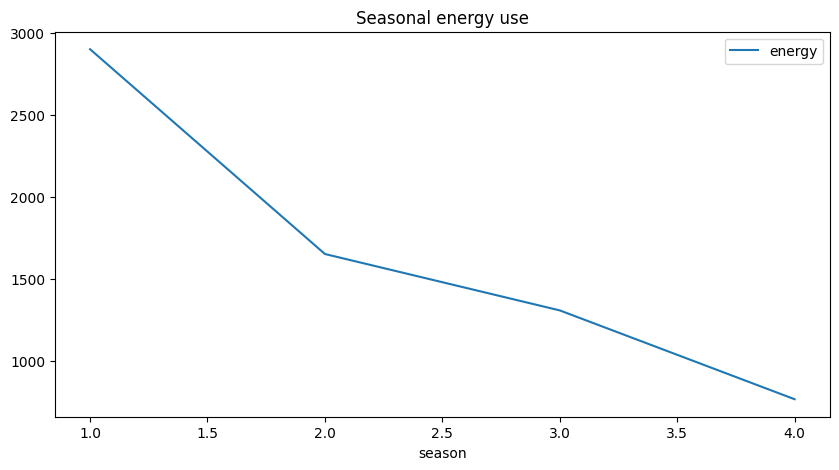

In [120]:
# Seasonal use
df.loc[:,['energy', 'season']].groupby(['season']).sum().plot(
    figsize=(10, 5), title="Seasonal energy use")

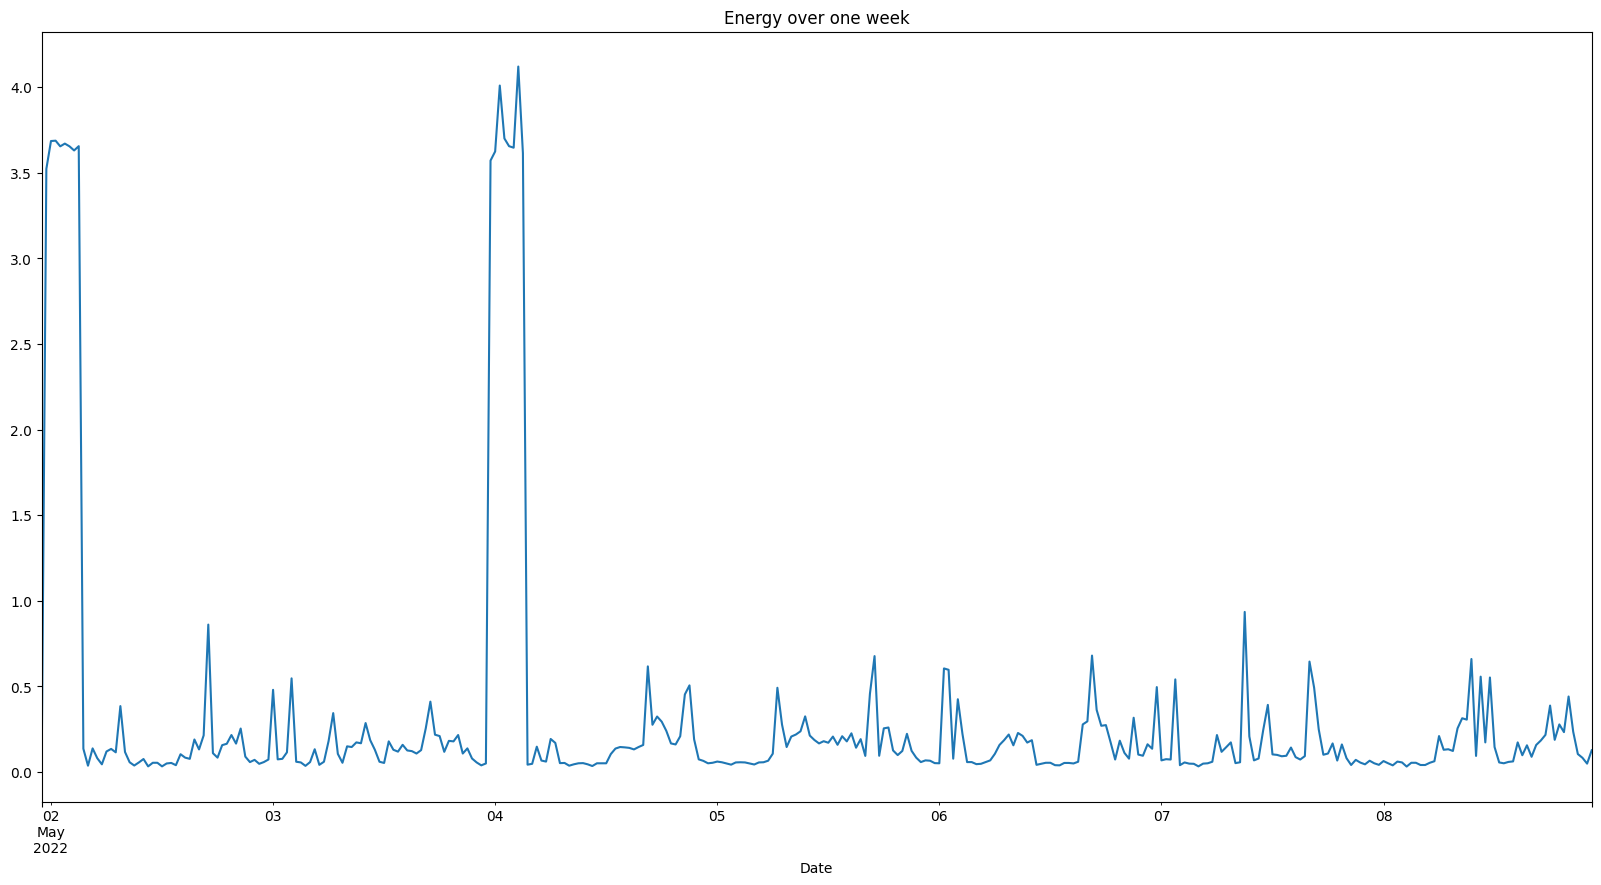

In [109]:
# One week in May
df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
         'energy'].plot(figsize=(20, 10), title="Energy over one week");


## Create Averages

Need average use for different days (e.g. weekday in winter, weekend in summer, etc...)